## Get data from bucket

In [74]:
import boto3
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import os, sys
from PIL import Image



In [75]:
# Define your S3 bucket and the image key
bucket_name = 's3-avalanche-guard'
positive_image_key = 'data/experiments/exp01-terrain-binary/train/positive/2015-03-07 rosskogel-windegg (3).jpg'
negative_image_key = 'data/experiments/exp01-terrain-binary/train/negative/ILSVRC2012_val_00000004_n04263257.JPEG'


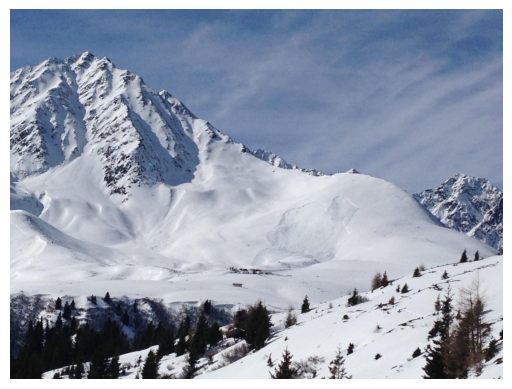

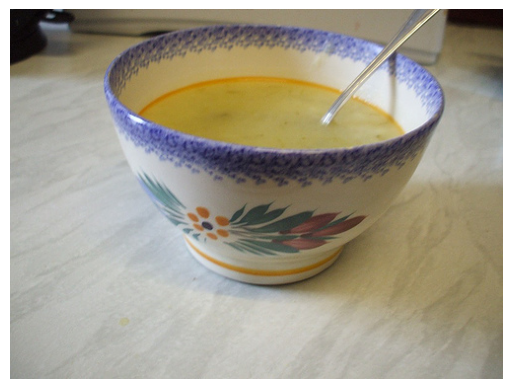

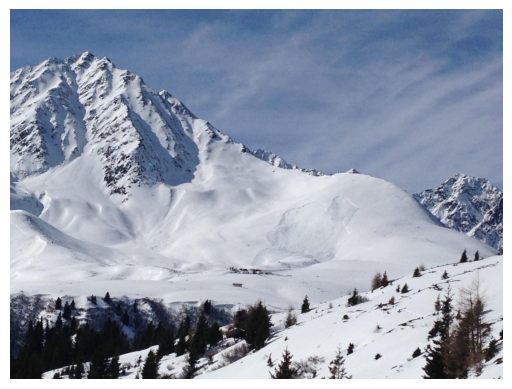

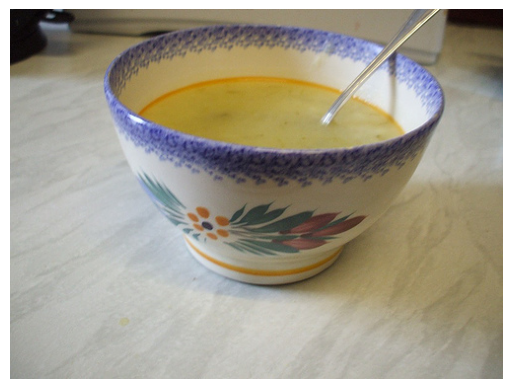

In [76]:
# Initialize a session using Amazon S3
s3 = boto3.client('s3')

# Get the image from S3
response = s3.get_object(Bucket=bucket_name, Key=positive_image_key)
image_data = response['Body'].read()

# Open the image
image = Image.open(BytesIO(image_data))

# Plot the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

# Negative Image
# Get the image from S3
response = s3.get_object(Bucket=bucket_name, Key=negative_image_key)
image_data = response['Body'].read()

# Open the image
image = Image.open(BytesIO(image_data))

# Plot the image
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()


## Train an Efficient Net model for binary classification

In [77]:
!pip install -q tensorflow==2.11.0 

In [78]:
!pip install -q pydot

In [79]:
!pip install -q graphviz

In [8]:
#!pip install -q --upgrade keras
#!pip install -q --upgrade tensorflow

#!pip install -q keras-nightly
#!pip install -q tensorflow==2.12.0 --user


In [80]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras import layers
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import utils as kutils
#from keras import ops as kops



import boto3
import os

In [14]:
print(tf.__version__)
#print(layers.__version__)

2.11.0


In [81]:
print(tf.__version__)

2.11.0


2.11.0


In [82]:
# Set the S3 bucket paths
# Set up the S3 bucket paths
s3_bucket = 's3-avalanche-guard'
s3_directory_key = 'data/experiments/exp01-terrain-binary/'

#s3_train ='cropped_images_noaugm_TrainValTest_balanced/train'
#s3_val = 'cropped_images_noaugm_TrainValTest_balanced/val'
#s3_test = 'cropped_images_noaugm_TrainValTest_balanced/test'

In [83]:
# Local directory to save images
local_directory = 'AR/images/local_image_directory'

# Create the local directory if it doesn't exist
if not os.path.exists(local_directory):
    os.makedirs(local_directory)


In [85]:
#### DO NOT RUN
RUN_THIS = False

# Initialize a session using Amazon S3
s3 = boto3.client('s3')

# List all objects in the S3 directory
paginator = s3.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket_name, Prefix=s3_directory_key)



if RUN_THIS:
    # Download each image and recreate the folder structure
    for page in pages:
        for obj in page['Contents']:
            key = obj['Key']
            if key.endswith('/'):  # Skip directories
                continue
            # Recreate the directory structure locally
            relative_path = os.path.relpath(key, s3_directory_key)
            local_file_path = os.path.join(local_directory, relative_path)
            local_file_dir = os.path.dirname(local_file_path)
            if not os.path.exists(local_file_dir):
                os.makedirs(local_file_dir)
            # Download the file
            s3.download_file(bucket_name, key, local_file_path)

            # resize
            size = 224, 224
            #outfile = os.path.splitext(local_file_path)[0] + ".jpg"
            im = Image.open(local_file_path)
            im.thumbnail(size, Image.Resampling.LANCZOS)
    #im.save(local_file_path, "JPEG")
else:
    print("Skipped downloading images from s3")

Skipped downloading images from s3


In [86]:
# Local Directory paths

local_train = os.path.join(local_directory, 'train')
local_val =  os.path.join(local_directory, 'val')
local_test =  os.path.join(local_directory, 'test')

In [109]:
# Function to load datasets
def load_datasets(img_dir: [str], img_size=(224, 224), batch_size=32):

    train_dataset = None
    val_dataset = None
    test_dataset = None

    if len(img_dir) >= 1:
        train_dir = img_dir[0]
        print(f"train dir:{train_dir}")
        train_dataset = image_dataset_from_directory(
            train_dir,
            labels='inferred',
            class_names=['negative', 'positive'],
            label_mode='int',
            batch_size=batch_size,
            image_size=img_size,
            shuffle=True
        )
        val_dataset = None
        test_dataset = None
    
    if len(img_dir) >= 2:
        val_dir = img_dir[1]
        print(f"val dir:{val_dir}")
        val_dataset = image_dataset_from_directory(
            val_dir,
            labels='inferred',
            class_names=['negative', 'positive'],
            label_mode='int',
            batch_size=batch_size,
            image_size=img_size,
            shuffle=False
        )

    if len(img_dir) >= 3:
        test_dir = img_dir[2]
        print(f"test dir:{test_dir}")
        test_dataset = image_dataset_from_directory(
            test_dir,
            labels='inferred',
            class_names=['negative', 'positive'],
            label_mode='int',
            batch_size=batch_size,
            image_size=img_size,
            shuffle=False
        )

        
    return train_dataset, val_dataset, test_dataset

In [119]:
# Load datasets
train_dataset, val_dataset, test_dataset = load_datasets([local_train, local_val, local_test],(224, 224),32)

Found 5043 files belonging to 2 classes.


2024-07-03 19:34:04.131163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-03 19:34:04.132964: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-03 19:34:04.133048: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-07-03 19:34:04.133100: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-07-03 19:34:04.133152: W tensorflow/c

Found 1441 files belonging to 2 classes.
Found 722 files belonging to 2 classes.


train dir:AR/images/local_image_directory/train
Found 5043 files belonging to 2 classes.
val dir:AR/images/local_image_directory/val
Found 1441 files belonging to 2 classes.
test dir:AR/images/local_image_directory/test
Found 722 files belonging to 2 classes.


In [111]:
type(train_dataset)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [112]:
# Get cardinality
# Cardinality is images/batch size
print(f"Number of training samples: {train_dataset.cardinality()}")
print(f"Number of validation samples: {val_dataset.cardinality()}")
print(f"Number of test samples: {test_dataset.cardinality()}")
print(train_dataset.class_names)

Number of training samples: 158
Number of validation samples: 46
Number of test samples: 23
['negative', 'positive']


Number of training samples: 158
Number of validation samples: 46
Number of test samples: 23


#### Augment data

some reference from https://keras.io/guides/transfer_learning/

In [113]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


# aument only train dataset
train_dataset_aug = train_dataset.map(lambda x, y: (data_augmentation(x), y))


<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


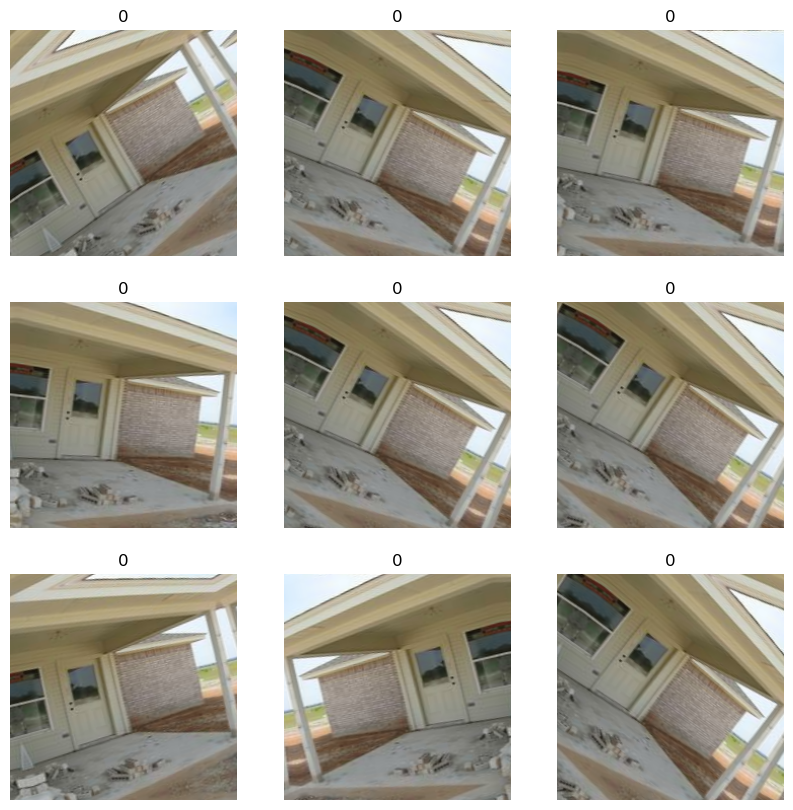

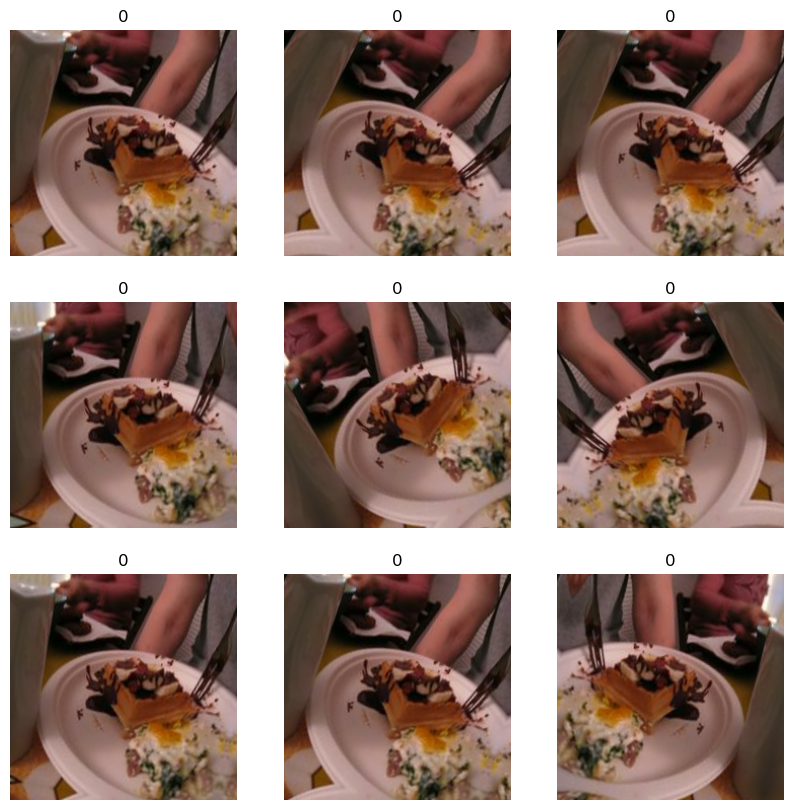

In [120]:
#visualize the augmented data
print(train_dataset)
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")


In [126]:
# Function to build the model
def build_model(num_classes):
    base_model = EfficientNetV2B0EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.2)(x)  # Regularize with dropout
    predictions = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
    
    layerRange = []
    for _layer in model.layers:
        if _layer not in base_model.layers:
            layerRange.append(_layer.name)
            
    trainable_layers = len(layerRange)
    for idx,_layer in enumerate(layerRange):
        if idx != 0 and idx != trainable_layers-1:
            layerRange.remove(_layer)
        
    model.summary(show_trainable=True, layer_range=layerRange)    
        
        
    
    return model

In [123]:
print(train_dataset.class_names)
y = set(np.concatenate([y for x, y in train_dataset_aug], axis=0))
print(f"y is {y}")

['negative', 'positive']
y is {0, 1}


['negative', 'positive']


In [127]:
# Build the model
num_classes = len(train_dataset.class_names)
model = build_model(num_classes)

# Compile the model
model.compile(optimizer=Adam(), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])



Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 global_average_pooling2d (Glob  (None, 1280)        0           ['top_activation[0][0]']         Y          
 alAveragePooling2D)                                                                                         
                                                                                                             
 dense (Dense)                  (None, 1024)         1311744     ['global_average_pooling2d[0][0  Y          
                                                                 ]']                                         
                                                                                                             
 dropout (Dropout)              (None, 1024)         0           ['dense[0][0]']                  Y      

In [30]:
# Train the model

_epochs = 1

history = model.fit(train_dataset, validation_data=val_dataset, epochs=_epochs)


158/158 [==============================] - 129s 778ms/step - loss: 0.0241 - accuracy: 0.9923 - val_loss: 0.0350 - val_accuracy: 0.9903


In [128]:
print(model)

In [32]:
#model.summary()

In [129]:
local_model_path = 'AR/models/Binary_TerrainOrNot_EfficientNetV2S_1'  # Local path to save the model
model.save(local_model_path, save_format='tf')

INFO:tensorflow:Assets written to: AR/models/Binary_TerrainOrNot_EfficientNetV2S_1/assets


INFO:tensorflow:Assets written to: AR/models/Binary_TerrainOrNot_EfficientNetV2S_1/assets


INFO:tensorflow:Assets written to: AR/models/Binary_TerrainOrNot_EfficientNetV2S_1/assets


INFO:tensorflow:Assets written to: AR/models/Binary_TerrainOrNot_EfficientNetV2S_1/assets


In [35]:
'''
tf.keras.utils.plot_model(
    model,
    to_file='AR/models/Binary_TerrainOrNot_EfficientNetV2S_1.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=False,
    dpi=200,
    show_layer_activations=False,
    show_trainable=False,
    **kwargs
)
'''

#tf.keras.utils.plot_model(model)



"\ntf.keras.utils.plot_model(\n    model,\n    to_file='AR/models/Binary_TerrainOrNot_EfficientNetV2S_1.png',\n    show_shapes=False,\n    show_dtype=False,\n    show_layer_names=False,\n    rankdir='TB',\n    expand_nested=False,\n    dpi=200,\n    show_layer_activations=False,\n    show_trainable=False,\n    **kwargs\n)\n"

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

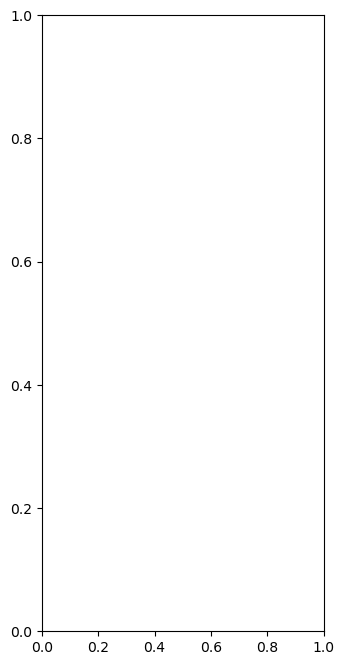

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

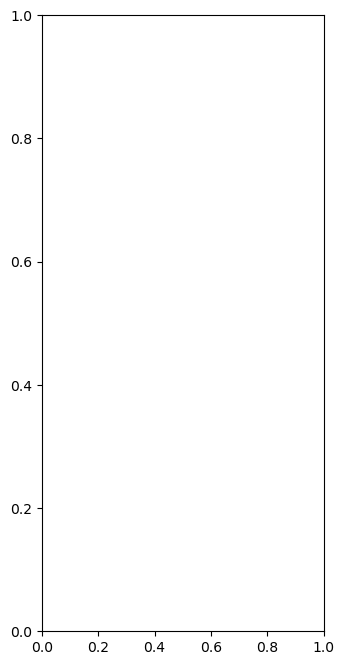

In [132]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Run Inference from the model

In [146]:
# load test dataset 

test_dataset = image_dataset_from_directory(
        local_test,
        labels='inferred',
        label_mode='int',
        batch_size=32,
        image_size=(224, 224),
        shuffle=False
    )
    

Found 722 files belonging to 2 classes.


Found 722 files belonging to 2 classes.


In [148]:
output = model.predict(traintest_dataset) 

158/158 [==============================] - 272s 2s/step


23/23 [==============================] - 39s 2s/step


In [133]:
print(output.shape)
print(tf.data.experimental.cardinality(test_dataset))
print(test_dataset.cardinality().numpy())


(5043, 2)
tf.Tensor(23, shape=(), dtype=int64)
23


In [ ]:
print(output)

In [156]:
print(np.array(train_dataset.take(42)))

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


OLabel=1,PLabel=0.41,0.59
OLabel=1,PLabel=0.54,0.46
OLabel=0,PLabel=0.46,0.54
OLabel=0,PLabel=0.33,0.67
OLabel=1,PLabel=0.35,0.65
OLabel=0,PLabel=0.47,0.53
OLabel=0,PLabel=0.54,0.46
OLabel=0,PLabel=0.46,0.54
OLabel=0,PLabel=0.44,0.56
OLabel=0,PLabel=0.54,0.46
OLabel=1,PLabel=0.36,0.64
OLabel=1,PLabel=0.37,0.63
OLabel=0,PLabel=0.44,0.56
OLabel=1,PLabel=0.44,0.56
OLabel=1,PLabel=0.53,0.47
OLabel=0,PLabel=0.36,0.64
OLabel=0,PLabel=0.43,0.57
OLabel=1,PLabel=0.55,0.45
OLabel=1,PLabel=0.41,0.59
OLabel=0,PLabel=0.44,0.56
OLabel=0,PLabel=0.52,0.48
OLabel=0,PLabel=0.53,0.47
OLabel=0,PLabel=0.41,0.59
OLabel=0,PLabel=0.43,0.57
OLabel=1,PLabel=0.43,0.57
OLabel=1,PLabel=0.54,0.46
OLabel=1,PLabel=0.5,0.5
OLabel=1,PLabel=0.54,0.46
OLabel=0,PLabel=0.55,0.45
OLabel=0,PLabel=0.51,0.49
OLabel=1,PLabel=0.54,0.46
OLabel=1,PLabel=0.4,0.6
OLabel=0,PLabel=0.41,0.59
OLabel=0,PLabel=0.54,0.46
OLabel=0,PLabel=0.46,0.54
OLabel=0,PLabel=0.33,0.67
OLabel=0,PLabel=0.35,0.65
OLabel=1,PLabel=0.47,0.53
OLabel=0,PLabel=

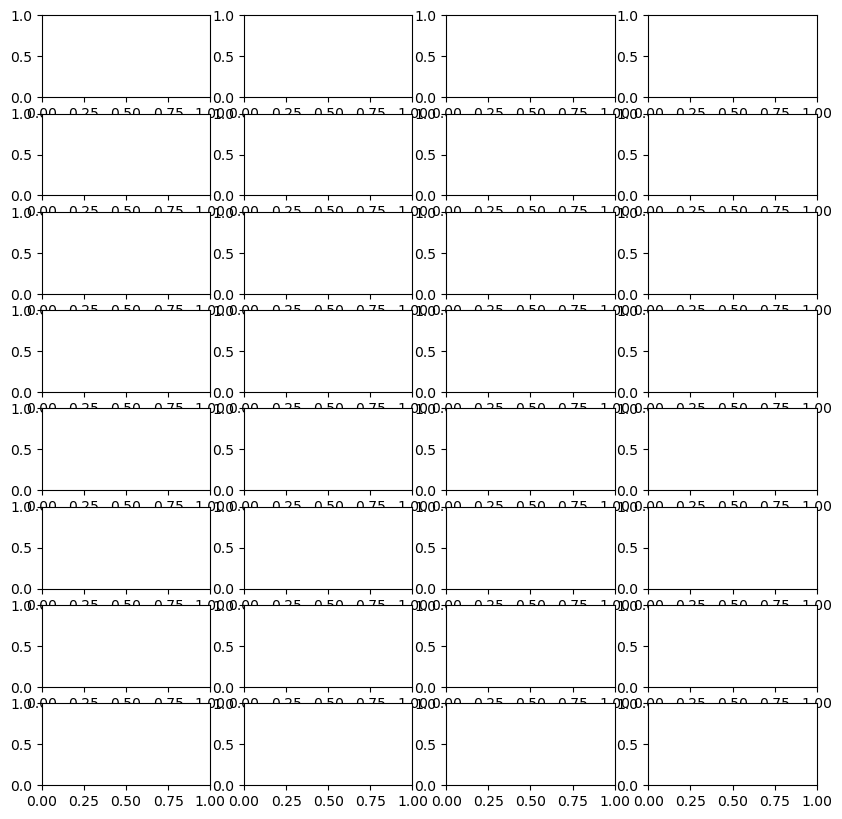

In [166]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(42):
    #print(np.array(images))
    #print(np.array(labels))
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        
        #neg_prob = float(output[i][0]) #round(float(output[i][0]),2)
        #pos_prob = float(output[i][1]) #round(float(output[i][1]),2)

        neg_prob = round(float(output[i][0]),2)
        pos_prob = round(float(output[i][1]),2)
        
        if pos_prob > neg_prob:
            pred_class = "Terrain"
        else:
            pred_class = "Not-a-Terrain"
        
        #print(labels[i],pos_prob)
        print(f"OLabel={labels[i]},PLabel={neg_prob},{pos_prob}")
        #plt.imshow(np.array(images[i]).astype("uint8"))
        #plt.title(f"OLabel={labels[i]},PLabel={neg_prob},{pos_prob}", fontsize = 6)
        #plt.axis("off")

#print(train_dataset.label)

Motivation - https://keras.io/examples/vision/image_classification_from_scratch/

1/1 [==============================] - 0s 124ms/step
This image is 47.86% Not-A-Terrain and 52.14% Terrain.


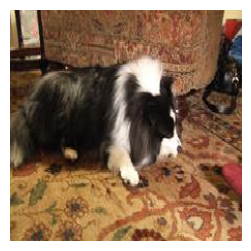

1/1 [==============================] - 0s 121ms/step
This image is 38.80% Not-A-Terrain and 61.20% Terrain.


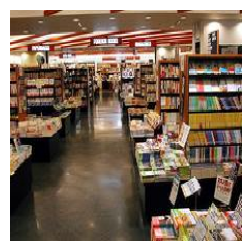

1/1 [==============================] - 0s 118ms/step
This image is 49.57% Not-A-Terrain and 50.43% Terrain.


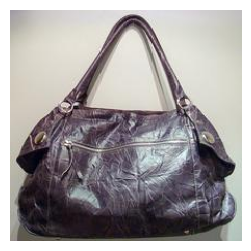

1/1 [==============================] - 0s 124ms/step
This image is 56.36% Not-A-Terrain and 43.64% Terrain.


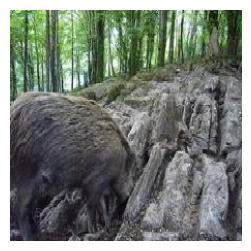

1/1 [==============================] - 0s 117ms/step
This image is 47.16% Not-A-Terrain and 52.84% Terrain.


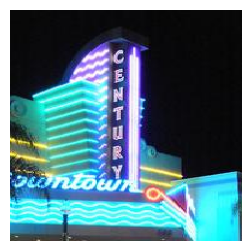

1/1 [==============================] - 0s 113ms/step
This image is 46.75% Not-A-Terrain and 53.25% Terrain.


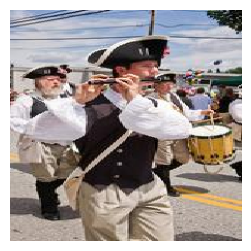

1/1 [==============================] - 0s 114ms/step
This image is 38.32% Not-A-Terrain and 61.68% Terrain.


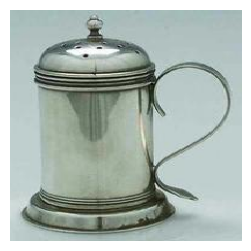

1/1 [==============================] - 0s 117ms/step
This image is 47.54% Not-A-Terrain and 52.46% Terrain.


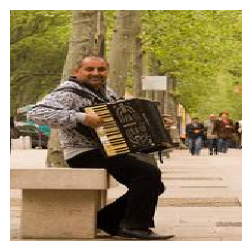

1/1 [==============================] - 0s 115ms/step
This image is 51.95% Not-A-Terrain and 48.05% Terrain.


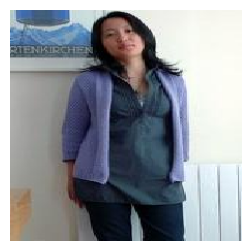

1/1 [==============================] - 0s 121ms/step
This image is 50.91% Not-A-Terrain and 49.09% Terrain.


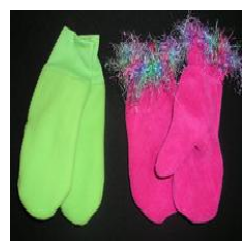

1/1 [==============================] - 0s 120ms/step
This image is 56.23% Not-A-Terrain and 43.77% Terrain.


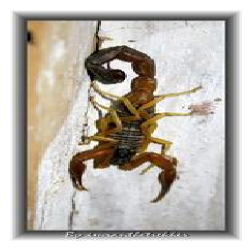

1/1 [==============================] - 0s 122ms/step
This image is 46.82% Not-A-Terrain and 53.18% Terrain.


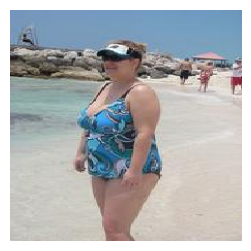

1/1 [==============================] - 0s 119ms/step
This image is 41.49% Not-A-Terrain and 58.51% Terrain.


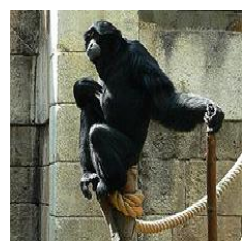

1/1 [==============================] - 0s 117ms/step
This image is 45.76% Not-A-Terrain and 54.24% Terrain.


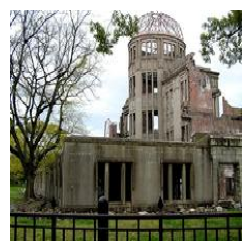

1/1 [==============================] - 0s 115ms/step
This image is 39.36% Not-A-Terrain and 60.64% Terrain.


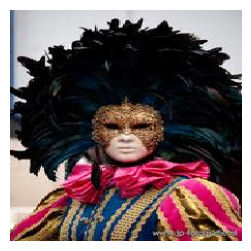

1/1 [==============================] - 0s 124ms/step
This image is 36.59% Not-A-Terrain and 63.41% Terrain.


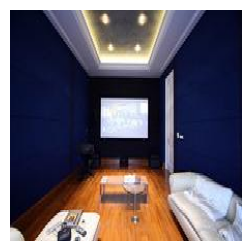

1/1 [==============================] - 0s 122ms/step
This image is 51.59% Not-A-Terrain and 48.41% Terrain.


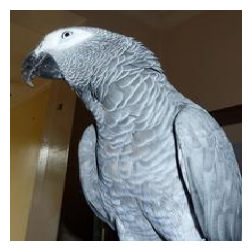

1/1 [==============================] - 0s 117ms/step
This image is 45.82% Not-A-Terrain and 54.18% Terrain.


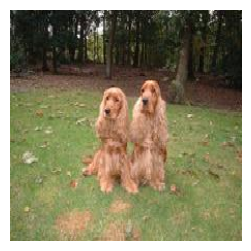

1/1 [==============================] - 0s 117ms/step
This image is 58.79% Not-A-Terrain and 41.21% Terrain.


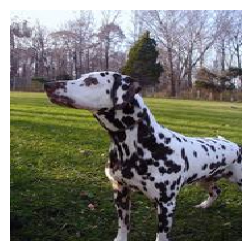

1/1 [==============================] - 0s 116ms/step
This image is 45.97% Not-A-Terrain and 54.03% Terrain.


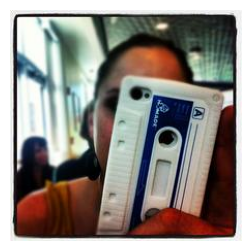

1/1 [==============================] - 0s 119ms/step
This image is 54.41% Not-A-Terrain and 45.59% Terrain.


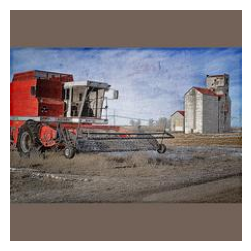

1/1 [==============================] - 0s 120ms/step
This image is 25.43% Not-A-Terrain and 74.57% Terrain.


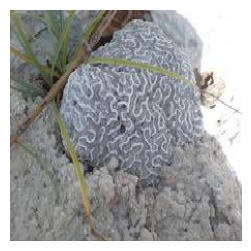

1/1 [==============================] - 0s 122ms/step
This image is 54.89% Not-A-Terrain and 45.11% Terrain.


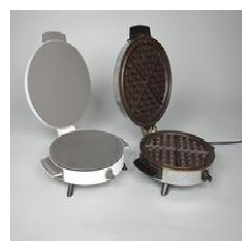

1/1 [==============================] - 0s 134ms/step
This image is 52.71% Not-A-Terrain and 47.29% Terrain.


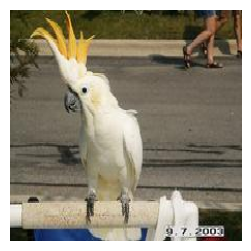

1/1 [==============================] - 0s 121ms/step
This image is 49.96% Not-A-Terrain and 50.04% Terrain.


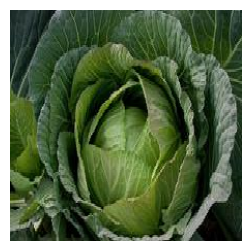

1/1 [==============================] - 0s 122ms/step
This image is 47.04% Not-A-Terrain and 52.96% Terrain.


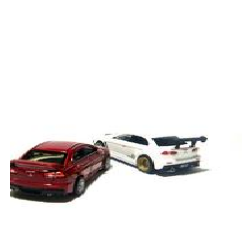

1/1 [==============================] - 0s 123ms/step
This image is 55.65% Not-A-Terrain and 44.35% Terrain.


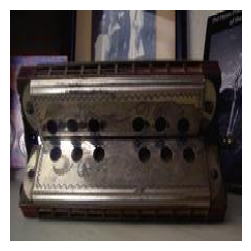

1/1 [==============================] - 0s 123ms/step
This image is 58.39% Not-A-Terrain and 41.61% Terrain.


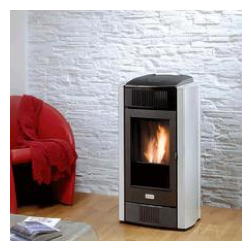

1/1 [==============================] - 0s 121ms/step
This image is 51.18% Not-A-Terrain and 48.82% Terrain.


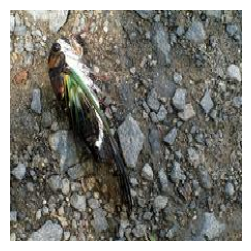

1/1 [==============================] - 0s 124ms/step
This image is 54.26% Not-A-Terrain and 45.74% Terrain.


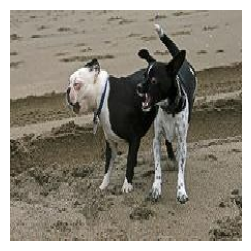

In [152]:

# import required module

#print(directory) 

# iterate over files in
# that directory
i=0
LIMIT = 30
directory = local_train + "/negative"
image_size = (224,224)


for filename in os.listdir(directory):
    i=i+1
    ##pred_class_arr = output[i-1]
    ##if pred_class_arr[1] > pred_class_arr[0]:
    ##    pred_class = "Terrain"
    ##else:
    ##    pred_class = "Not-a-Terrain"
    ##print(f"Index = {i} - Class = {pred_class}  -  ClassArray={pred_class_arr}")
    if i> LIMIT:
        break
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        
        img = kutils.load_img(f, target_size=image_size)
        #plt.imshow(img)

        img_array = kutils.img_to_array(img)
        img_array = np.expand_dims(img_array, 0)  # Create batch axis

        predictions = model.predict(img_array)
        pred_neg = predictions[0][0]
        pred_pos = predictions[0][1]
        
        pos_score = round(pred_pos, 5)
        #print(f"** Pred_neg_raw = {pred_neg} , Pred_pos_raw = {pred_pos} , Istoal 100%{pred_pos + pred_neg}. This image is {100 * (1 - pos_score):.2f}% Not-A-Terrain and {100 * pos_score:.2f}% Terrain.")
        print(f"This image is {100 * (1 - pos_score):.2f}% Not-A-Terrain and {100 * pos_score:.2f}% Terrain.")

        # Open the image
        ###image = mpimg.imread(f)
        plt.figure(figsize=(6, 3))

        # Plot the image
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        plt.show()

        
print(